In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from modules import utils
import tensorflow as tf
import gpflow
from gpflow import set_trainable
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
from math import sqrt
import plotly.express
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# jinja_rmse_list = [12.638214603741016, 22.159277937464626, 10.63045731661557, 16.050430237146696, 14.22064590909618,
#                    20.841724690067746, 15.494020345189183, 12.889885966027427, 20.815040220841407, 
#                    23.03540785035169]

In [4]:
# closest_to_mean = min(jinja_rmse_list, key=lambda x:abs(x-np.mean(jinja_rmse_list)))
# closest_to_mean

In [5]:
# closest_to_median = min(jinja_rmse_list, key=lambda x:abs(x-np.median(jinja_rmse_list)))
# closest_to_median

#### The data

In [6]:
jinja_df = pd.read_csv('../data/jinja_data.csv', parse_dates=['timestamp'])
jinja_df.head()

,site_name,latitude,longitude,city,timestamp,pm2_5_calibrated_value,pm2_5_raw_value,pm10_raw_value,pm10_calibrated_value,site_id,device_number,device_name
0,"Jinja Main Street, Jinja",0.437337,33.211051,Jinja,2021-09-01 00:00:00+00:00,NaN,NaN,NaN,NaN,60d058c8048305120d2d6142,689753,aq_23
1,"Jinja Main Street, Jinja",0.437337,33.211051,Jinja,2021-09-01 01:00:00+00:00,NaN,NaN,NaN,NaN,60d058c8048305120d2d6142,689753,aq_23
2,"Jinja Main Street, Jinja",0.437337,33.211051,Jinja,2021-09-01 02:00:00+00:00,NaN,NaN,NaN,NaN,60d058c8048305120d2d6142,689753,aq_23
3,"Jinja Main Street, Jinja",0.437337,33.211051,Jinja,2021-09-01 03:00:00+00:00,NaN,NaN,NaN,NaN,60d058c8048305120d2d6142,689753,aq_23
4,"Jinja Main Street, Jinja",0.437337,33.211051,Jinja,2021-09-01 04:00:00+00:00,NaN,NaN,NaN,NaN,60d058c8048305120d2d6142,689753,aq_23


In [7]:
latitudes = jinja_df['latitude'].unique()
longitudes = jinja_df['longitude'].unique()
device_ids = jinja_df['device_number'].unique()
site_names = jinja_df['site_name'].unique()
len(latitudes), len(longitudes), len(device_ids), len(site_names)

(10, 10, 10, 10)

In [8]:
site_names

array(['Jinja Main Street, Jinja', 'Kimaka, Jinja', 'YMCA, Jinja',
       'Rubaga Ward, Jinja City', 'Katende Ward, Jinja',
       'City Council, Jinja', 'Walukuba East, Jinja City',
       'Kivubuka Budondo, Jinja', 'Kyabirwa Namizzi, Jinja',
       'Mpumudde, Jinja'], dtype=object)

In [9]:
new_site_names = ['Jinja Main Street', 'Kimaka', 'YMCA', 'Rubaga Ward', 'Katende Ward', 'City Council', 
                  'Walukuba East', 'Kivubuka Budondo', 'Kyabirwa Namizzi', 'Mpumudde']

In [10]:
pre_final_df = pd.DataFrame()
cols = ['timestamp', 'latitude', 'longitude', 'site_name', 'pm2_5_calibrated_value']
for i, device_id in enumerate(device_ids):
    device_df = utils.get_device_data(jinja_df, device_id, cols)
    processed_df = utils.preprocessing(device_df)
    pre_final_df = pd.concat([pre_final_df, processed_df])
pre_final_df.reset_index(drop=True, inplace=True)
pre_final_df.head()

,time,latitude,longitude,site_name,pm2_5
0,452909.0,0.437337,33.211051,"Jinja Main Street, Jinja",12.2844
1,452910.0,0.437337,33.211051,"Jinja Main Street, Jinja",11.6507
2,452911.0,0.437337,33.211051,"Jinja Main Street, Jinja",22.3980
3,452912.0,0.437337,33.211051,"Jinja Main Street, Jinja",17.4937
4,452913.0,0.437337,33.211051,"Jinja Main Street, Jinja",25.1622


In [11]:
final_df = pre_final_df.drop(['site_name'], axis=1)
final_df.head()

,time,latitude,longitude,pm2_5
0,452909.0,0.437337,33.211051,12.2844
1,452910.0,0.437337,33.211051,11.6507
2,452911.0,0.437337,33.211051,22.3980
3,452912.0,0.437337,33.211051,17.4937
4,452913.0,0.437337,33.211051,25.1622


In [12]:
len(final_df)

13653

In [13]:
len(final_df.latitude.unique()), len(final_df.longitude.unique())

(10, 10)

In [14]:
f = lambda time: pd.Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

In [15]:
def cross_validation(final_df, idx, kernel_variance, lengthscales, likelihood_variance, trainable_kernel, 
                     trainable_variance, trainable_lengthscales):
#     device_indices = final_df[final_df.latitude==latitudes[idx]].index
    device_indices = pre_final_df[pre_final_df.site_name==site_names[idx]].index
#     device_df = jinja_df[jinja_df.device_number == device_ids[idx]]
#     assert(len(device_indices) == len(device_df)-device_df.pm2_5_calibrated_value.isna().sum())
    
    test_df = final_df.loc[device_indices]
    assert(len(test_df.longitude.unique()) == 1)
    
    train_df = pd.concat([final_df, test_df]).drop_duplicates(keep=False)
    assert(len(train_df.longitude.unique()) == len(longitudes)-1)
    assert len(final_df) == len(test_df) + len(train_df)
    
    X_train = train_df.iloc[:, 0:-1]
    y_train = train_df.iloc[:, -1]
    X_train, y_train = np.array(X_train), np.array(y_train).reshape(-1, 1)
    if X_train.shape[0] > 9999:
        X_train = X_train[::2, :]
        y_train = y_train[::2, :]
    
    X_test = test_df.iloc[:, 0:-1]
    y_test = test_df.iloc[:, -1]
    X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1, 1)
   
    
    if lengthscales == 'train_shape':
        lengthscales = np.ones(X_train.shape[1])
    
    if (lengthscales is None) & (kernel_variance is None):
        k = gpflow.kernels.RBF() + gpflow.kernels.Bias()
    elif lengthscales is None:
        k = gpflow.kernels.RBF(variance=kernel_variance) + gpflow.kernels.Bias()
    elif kernel_variance is None:
        k = gpflow.kernels.RBF(lengthscales=lengthscales) + gpflow.kernels.Bias()
    else:
        k = gpflow.kernels.RBF(lengthscales=lengthscales, variance=kernel_variance) + gpflow.kernels.Bias()
        
    m = gpflow.models.GPR(data=(X_train, y_train), kernel=k, mean_function=None)
    if likelihood_variance is None:
        pass
    else:
        m.likelihood.variance.assign(likelihood_variance)
    set_trainable(m.kernel.kernels[0].variance, trainable_kernel)
    set_trainable(m.likelihood.variance, trainable_variance)
    set_trainable(m.kernel.kernels[0].lengthscales, trainable_lengthscales)
    
    #optimization
    opt = gpflow.optimizers.Scipy()
    def objective_closure():
        return - m.log_marginal_likelihood()
    
    opt_logs = opt.minimize(objective_closure,
                            m.trainable_variables,
                            options=dict(maxiter=100))

    #prediction
    mean, var = m.predict_f(X_test)
    
    rmse = sqrt(mean_squared_error(y_test, mean.numpy()))
    mape = mean_absolute_percentage_error(y_test, mean.numpy())
    return rmse, mape, mean.numpy(), var.numpy(), X_test, y_test
    
#     return mean.numpy(), var.numpy(), Xtest, Ytest, round(rmse, 2)

In [16]:
lengthscale = [2, 0.008, 0.008]
likelihood_variance = 400
kernel_variance = None
trainable_kernel = True 
trainable_variance = False
trainable_lengthscale = True

In [17]:
site_names

array(['Jinja Main Street, Jinja', 'Kimaka, Jinja', 'YMCA, Jinja',
       'Rubaga Ward, Jinja City', 'Katende Ward, Jinja',
       'City Council, Jinja', 'Walukuba East, Jinja City',
       'Kivubuka Budondo, Jinja', 'Kyabirwa Namizzi, Jinja',
       'Mpumudde, Jinja'], dtype=object)

2023-08-17 00:30:03.937340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-17 00:30:03.937367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: PL1207-PRO.paris.inria.fr
2023-08-17 00:30:03.937370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: PL1207-PRO.paris.inria.fr
2023-08-17 00:30:03.937473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-08-17 00:30:03.937494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.125.06  Release Build  (dvs-builder@U16-A23-14-1)  Tue May 30 05:12:48 UTC 2023
GCC version:  gcc ve

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
689753 - Jinja Main Street successful


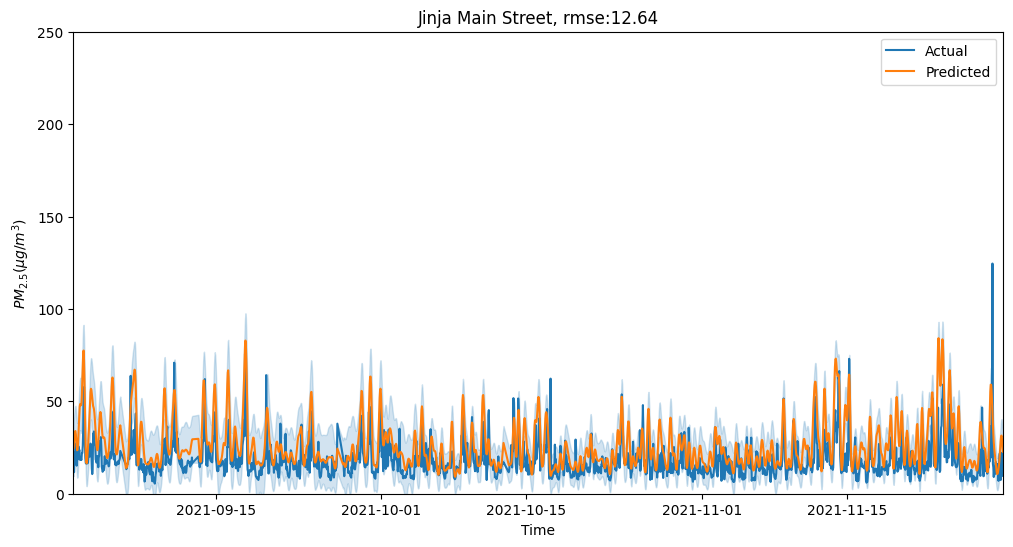

1014698 - Kimaka successful


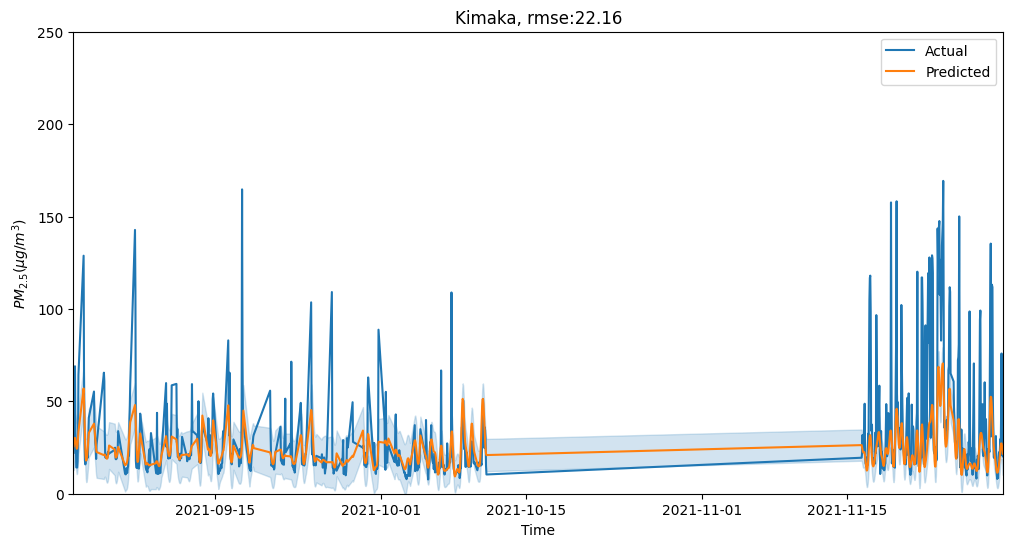

1014692 - YMCA successful


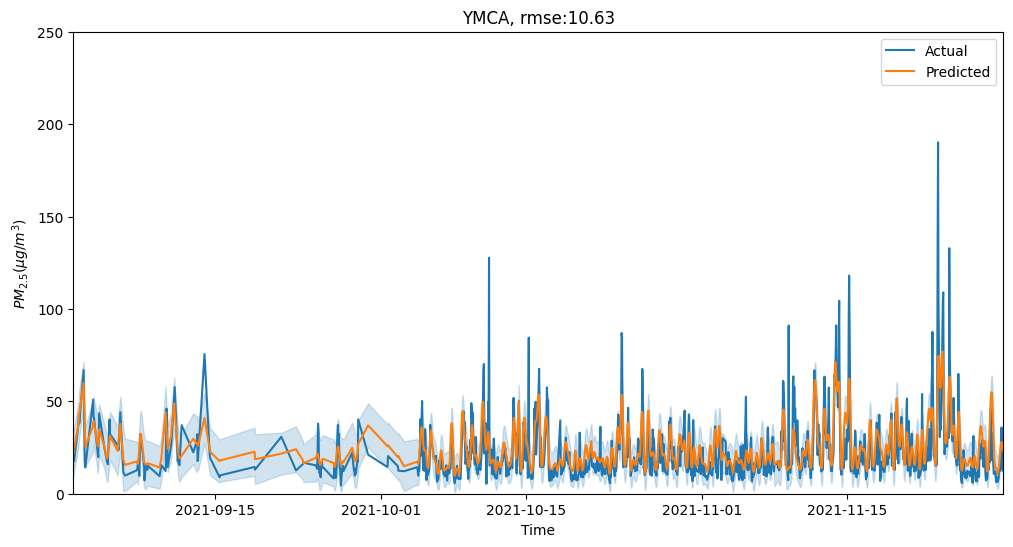

1014697 - Rubaga Ward successful


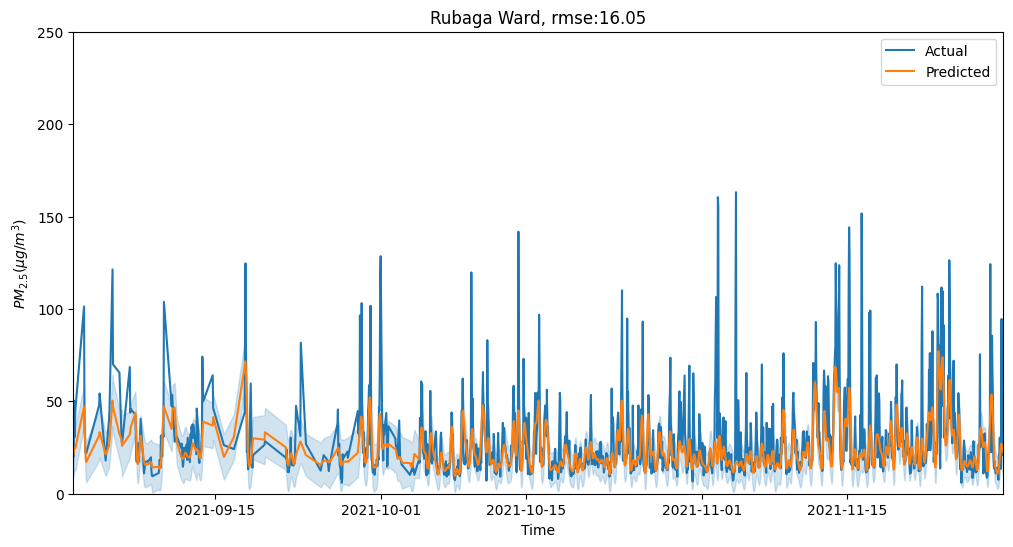

1290038 - Katende Ward successful


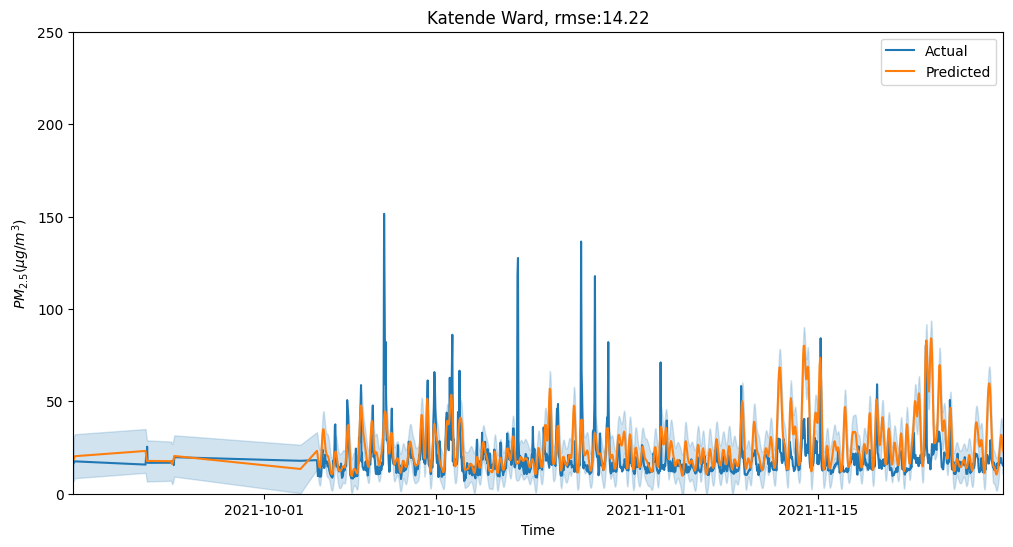

1373035 - City Council successful


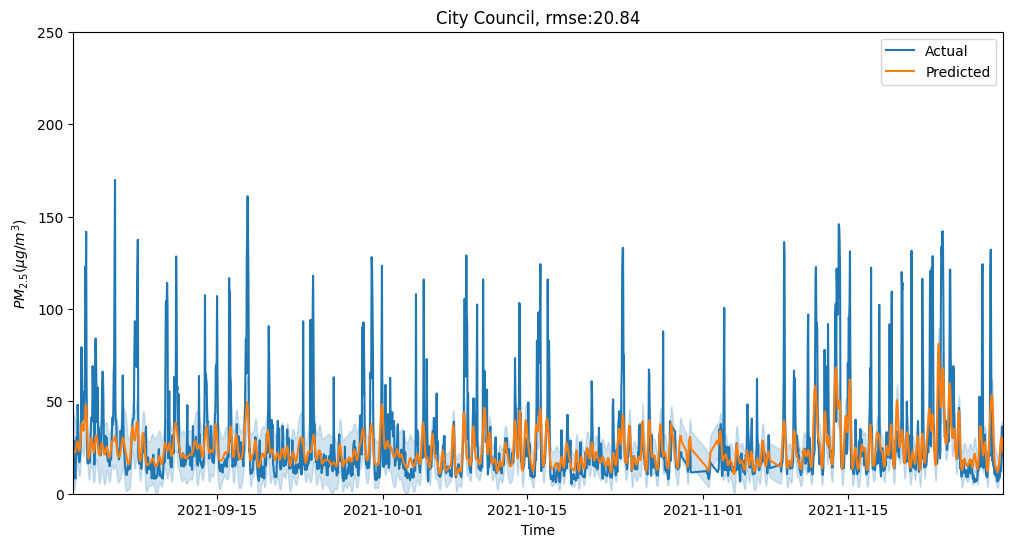

1373037 - Walukuba East successful


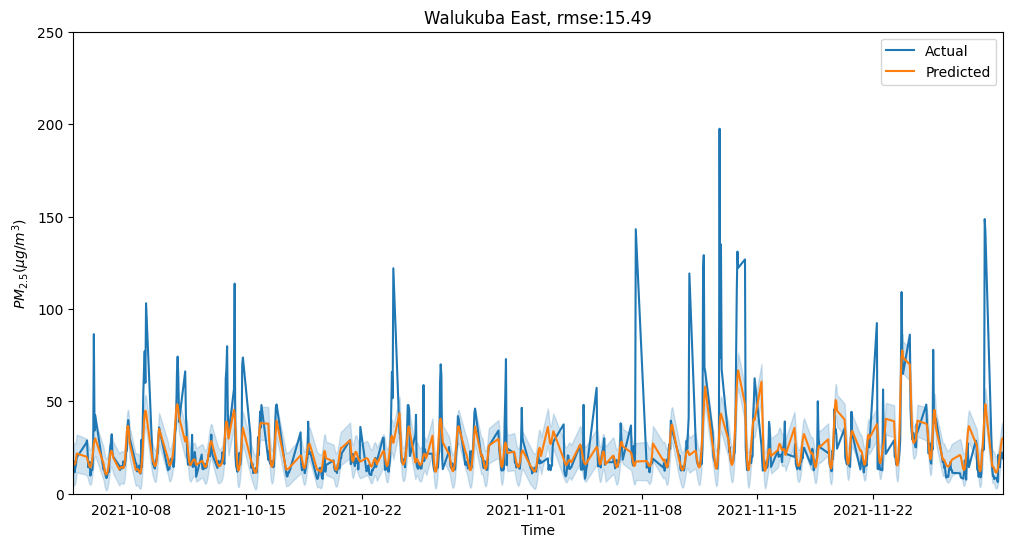

1373038 - Kivubuka Budondo successful


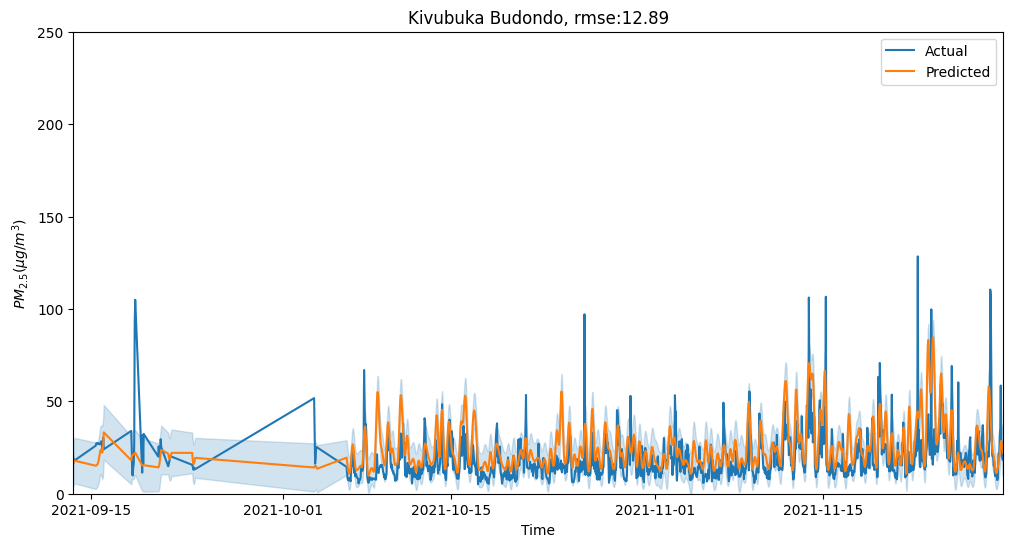

1373039 - Kyabirwa Namizzi successful


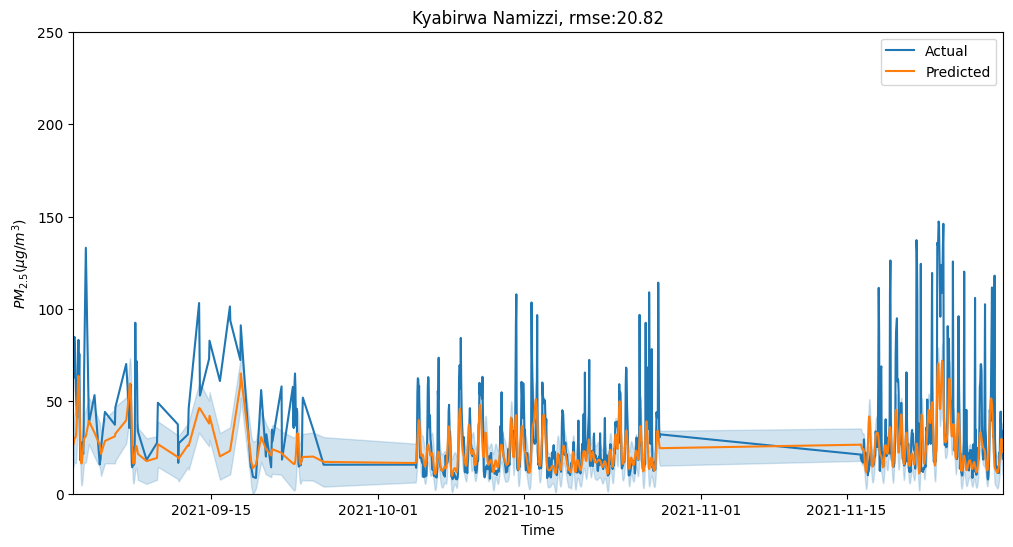

1379965 - Mpumudde successful


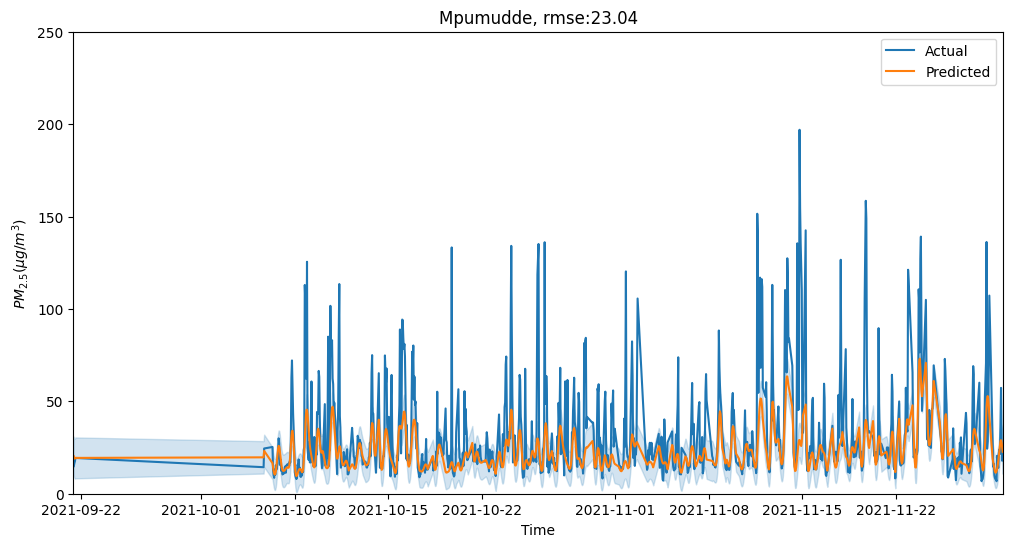

{'lengthscale': [2, 0.008, 0.008], 'likelihood_variance': 400, 'kernel_variance': None, 'trainable_kernel': True, 'trainable_variance': False, 'trainable_lengthscale': True, 'avg_rmse': 16.877510507654154, 'rmse_list': [12.638214603741016, 22.159277937464626, 10.63045731661557, 16.050430237146696, 14.22064590909618, 20.841724690067746, 15.494020345189183, 12.889885966027427, 20.815040220841407, 23.03540785035169], 'avg_mape': 0.383402490677985, 'mape_list': [0.589531716320795, 0.28962791585388287, 0.3982307169734864, 0.2588068303070695, 0.4887412002579675, 0.3713255108332165, 0.26413592154488996, 0.5659192590864704, 0.3190992954134291, 0.28860654018864185]}


In [18]:
results_df = pd.DataFrame()
rmse_list, mape_list = [], []
for i in range(len(site_names)):
    try:
        rmse, mape, mean, var, X_test, y_test = cross_validation(final_df, i, kernel_variance, lengthscale, 
                                                                 likelihood_variance, trainable_kernel, 
                                                                 trainable_variance, trainable_lengthscale)
        rmse_list.append(rmse)
        mape_list.append(mape)
        print(f'{device_ids[i]} - {new_site_names[i]} successful')
        plt.figure(figsize=(12,6))
        plt.title(f'{new_site_names[i]}, rmse:{round(rmse, 2)}')
        plt.xlim(f2(X_test[:,0]).min()-timedelta(hours=1), f2(X_test[:,0]).max()+timedelta(hours=1))
        plt.ylim(0, 250)
        plt.xlabel('Time')
        plt.ylabel('$PM_{2.5} (\mu g/m^3)$')
        plt.plot(f2(X_test[:, 0]), y_test, label='Actual')
        plt.plot(f2(X_test[:, 0]), mean, label='Predicted')
        plt.fill_between(f2(X_test[:, 0]),
                         mean[:,0]-1.96*np.sqrt(var[:, 0]),
                         mean[:,0]+1.96*np.sqrt(var[:, 0]),
                         color="C0",
                         alpha=0.2)
        plt.legend(loc='best')
        plt.savefig(f'../plots/final/{new_site_names[i]}.png') 
        plt.show()
    except Exception as e:
        print(e)
        print(f'{device_ids[i]} - {new_site_names[i]} failed')
        break

mean_rmse = np.mean(rmse_list)
mean_mape = np.mean(mape_list)
results_dict= {'lengthscale':lengthscale, 'likelihood_variance':likelihood_variance, 
               'kernel_variance':kernel_variance, 'trainable_kernel':trainable_kernel, 
               'trainable_variance':trainable_variance, 'trainable_lengthscale':trainable_lengthscale, 
               'avg_rmse':mean_rmse, 'rmse_list':rmse_list, 'avg_mape':mean_mape, 'mape_list':mape_list}
print(results_dict)
results_df = results_df.append(results_dict, ignore_index=True)
results_df.to_csv(f'../results/final_results_with_plots.csv', index=False)    

In [19]:
np.mean(rmse_list), np.mean(mape_list)

(16.877510507654154, 0.383402490677985)

In [20]:
rmse_list

[12.638214603741016,
 22.159277937464626,
 10.63045731661557,
 16.050430237146696,
 14.22064590909618,
 20.841724690067746,
 15.494020345189183,
 12.889885966027427,
 20.815040220841407,
 23.03540785035169]

In [21]:
mape_list

[0.589531716320795,
 0.28962791585388287,
 0.3982307169734864,
 0.2588068303070695,
 0.4887412002579675,
 0.3713255108332165,
 0.26413592154488996,
 0.5659192590864704,
 0.3190992954134291,
 0.28860654018864185]

In [22]:
np.mean(rmse_list), np.std(rmse_list), np.median(rmse_list), np.min(rmse_list), np.max(rmse_list)

(16.877510507654154,
 4.237822439747142,
 15.772225291167938,
 10.63045731661557,
 23.03540785035169)

#### delete from here

In [ ]:
# my_rmse = closest_to_mean
# idx = jinja_rmse_list.index(my_rmse)
# idx

In [ ]:
# rmse, mape, mean, var, X_test, y_test = cross_validation(final_df, idx, kernel_variance, lengthscale, 
#                                                          likelihood_variance, trainable_kernel, trainable_variance, 
#                                                          trainable_lengthscale)

In [ ]:
# X_test[:3]

In [ ]:
# plt.figure(figsize=(12,6))
# plt.title(f'{site_names[idx]}, rmse:{round(jinja_rmse_list[idx], 2)}')
# plt.xlim(f2(X_test[:,0]).min()-timedelta(hours=1), f2(X_test[:,0]).max()+timedelta(hours=1))
# plt.ylim(0,250)
# plt.plot(f2(X_test[:, 0]), y_test, label='Actual')
# plt.plot(f2(X_test[:, 0]), mean, label='Predicted')
# plt.fill_between(f2(X_test[:, 0]),
#                  mean[:,0]-1.96*np.sqrt(var[:, 0]),
#                  mean[:,0]+1.96*np.sqrt(var[:, 0]),
#                  color="C0",
#                  alpha=0.2)
# plt.legend(loc='best')
# plt.savefig(f'../plots/{site_names[idx]}.png') 
# plt.show()

#### end here